<a href="https://colab.research.google.com/github/nadavschwalb/image_processing/blob/main/Lab3_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3 – Quantization and Color Histogram Equalization**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# change working directory and verify files are accessible
%cd '/content/drive/My Drive/image_processing/Lab_2'
%ls -l




/content/drive/My Drive/image_processing/Lab_2
total 9241
-rw------- 1 root root  189097 Oct 27 19:29 autumn.bmp
-rw------- 1 root root   56220 Oct 27 19:41 baloons.bmp
-rw------- 1 root root  164700 Oct 28 13:57 dolphin.bmp
-rw------- 1 root root  152288 Oct 27 19:45 flower.bmp
-rw------- 1 root root 1124341 Oct 27 19:52 lab_2_preliminary.ipynb
-rw------- 1 root root  787012 Oct 27 19:59 lab_2_preliminary.pdf
-rw------- 1 root root  211381 Oct 28 12:57 Lab2_student.ipynb
-rw------- 1 root root   66888 Oct 28 12:46 lenna.gif
-rw------- 1 root root 6495394 Nov  9 21:06 MOT16-04-raw.mp4
-rw------- 1 root root     258 Nov  9 21:07 output.mp4
-rw------- 1 root root    5574 Oct 27 20:00 printtopdf.ipynb
-rw------- 1 root root  188467 Oct 28 13:53 tiger.bmp
-rw------- 1 root root   17496 Oct 27 19:37 WeatherVane.bmp


**Import the necessary libraries for Lab 3:**

In [4]:
%matplotlib inline 
import numpy as np
import cv2
import matplotlib.pylab as plt
from skimage import transform,io, color , img_as_ubyte
from sklearn import cluster
from sklearn.utils import shuffle

# Part 1: Quantization
___

1. Insert your function quant_img(img, N) from the preliminary report.

In [5]:
def quant_img(img,N):
  if not isinstance(N,int) or N <= 0:
    raise ValueError("N must be int greater than zero")
  quant = int(256/N)
  print(f"quantizing to {N} quants of size {quant}")
  return (img/quant).astype('uint8')*quant



2. Load the image of your choise as gray scale image and perform uniform quantization on your image to **2, 4, 8, 16, 32 and 64** gray levels.   
    From which quantization factor do you observe the problem of **false contours**? Attach relevant examples from the quantized images to demonstrate your answer.

quantizing to 2 quants of size 128
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 32 quants of size 8
quantizing to 64 quants of size 4


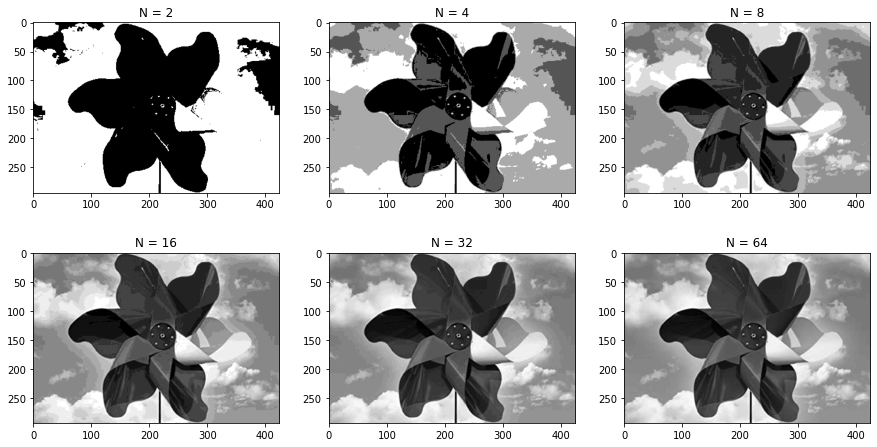

In [6]:
img = io.imread('WeatherVane.bmp')
grayscale_img = color.rgb2gray(img)
grayscale_img= img_as_ubyte(grayscale_img)
plt.figure(figsize=(15,12))
for i in range(1,7):
  plt.subplot(330 + i)
  plt.title(f"N = {2**i}")
  plt.imshow(quant_img(grayscale_img,2**i),cmap='gray')


in N =2 ,4 and 8 we can clearly see false contures esspecially in the bright areas. for example in N-4 the bright fin is indestinquishable from the background



quantizing to 4 quants of size 64
quantizing to 64 quants of size 4


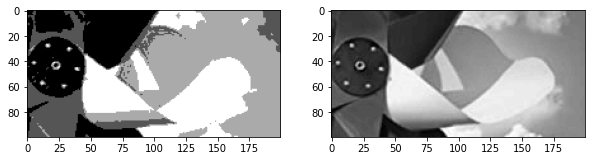

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(quant_img(grayscale_img,4)[100:200,200:400],cmap='gray')
plt.subplot(122)
plt.imshow(quant_img(grayscale_img,64)[100:200,200:400],cmap='gray')
plt.show()

3. Use the supplied function *imnoise()*, that adds Gaussian noise, on the image before quantization and test the effect on the false contours problem. Use zero mean noise with several values of variance.   
    You can use the quantization level that you chose in the previous section.
    
    What value of variance yields the optimal result? Attach examples of the quantized images with optimal and non-optimal variance values.

In [11]:
def imnoise(img, mean, std):
    noisy_img = img + np.random.normal(mean, std, img.shape)
    return np.clip(noisy_img, 0, 255)  # keep the bounds 

quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16


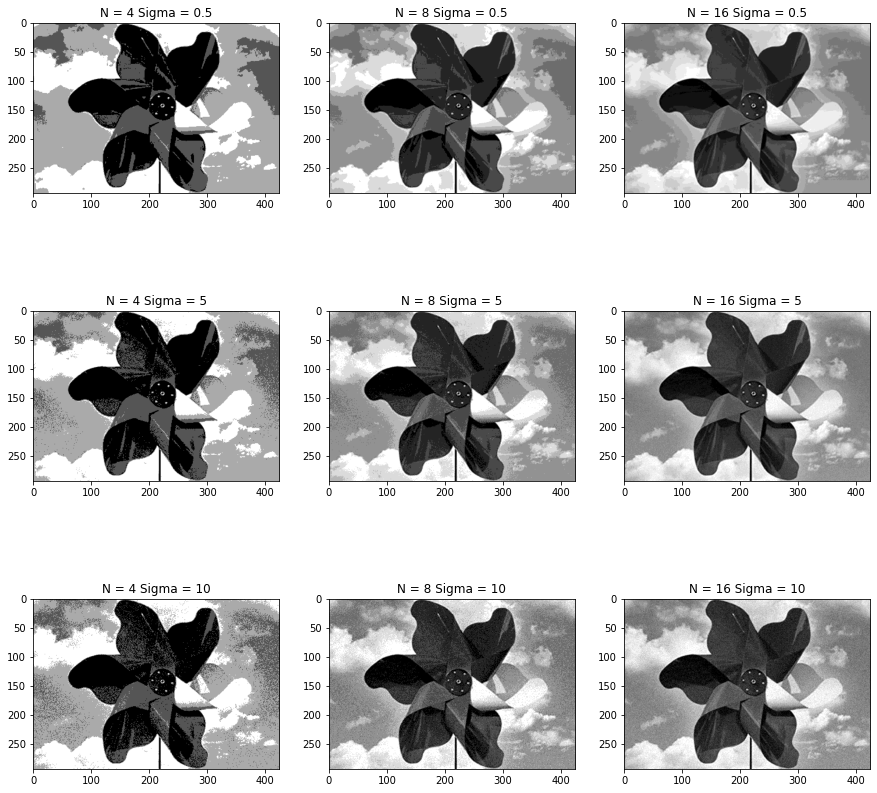

In [12]:
variances = [0.5,5,10]
quant_factors = [4,8,16]
plot_grid = len(variances)*100 + len(quant_factors)*10 + 1

plt.figure(figsize=(15,15))
for i,sigma in enumerate(variances):
  for j,N in enumerate(quant_factors):
    plt.subplot(plot_grid + i*len(quant_factors) +j)
    plt.title(f"N = {N} Sigma = {sigma}")
    uniform_quant_image = quant_img(imnoise(grayscale_img,0,sigma),N)
    plt.imshow(uniform_quant_image,cmap='gray')


adding some noise to the image makes sure that some of adjasent pixels will fall in diffrent quantization ranges and help "blend" the false contures. we found that a sigma of 5 is ideal.

a larger sigma results in clear image noise (salt and pepper)

quantizing to 8 quants of size 32
quantizing to 8 quants of size 32
quantizing to 8 quants of size 32


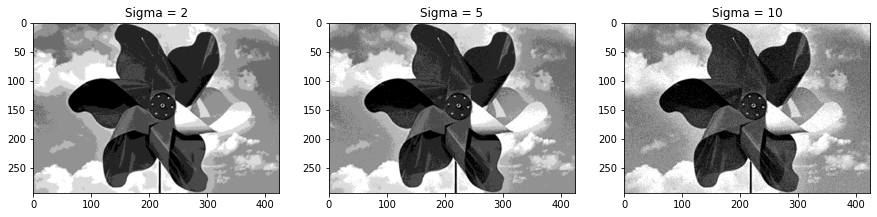

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(quant_img(imnoise(grayscale_img,0,2),8),cmap='gray')
plt.title("Sigma = 2")
plt.subplot(132)
plt.imshow(quant_img(imnoise(grayscale_img,0,5),8),cmap='gray')
plt.title("Sigma = 5")
plt.subplot(133)
plt.imshow(quant_img(imnoise(grayscale_img,0,10),8),cmap='gray')
plt.title("Sigma = 10")
plt.show()

4. perform quantization on your image using K-means to **2, 4, 8, 16, 32 and 64** gray levels. You may use the provided function. Plot the resulting histograms of both methods. What is the main difference?
    Compare your results to the results from the previous section.

In [16]:
def kmeans_quant_img(img,N):
    m,n = img.shape
    np.random.seed(0)
    image_array = img.reshape(-1,1)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = cluster.KMeans(n_clusters= N).fit(image_array_sample)   
    labels = kmeans.predict(image_array)
    q_img = np.zeros_like(img)
    label_idx = 0
    for i in range(m):
        for j in range(n):
            q_img[i][j] = kmeans.cluster_centers_[labels[label_idx]]
            label_idx += 1

    return q_img

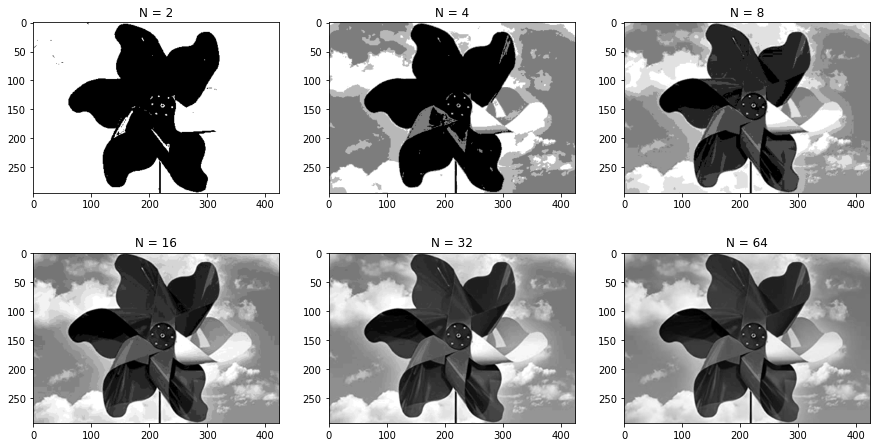

In [19]:
plt.figure(figsize=(15,12))
kmeans_quant_dict = {}
for i in range(1,7):
  plt.subplot(330 + i)
  plt.title(f"N = {2**i}")
  N_kmeans_quant_image = kmeans_quant_img(grayscale_img,2**i)
  plt.imshow(N_kmeans_quant_image,cmap='gray')
  kmeans_quant_dict[f"N = {2**i}"] = N_kmeans_quant_image



In [20]:
uniform_quant_dict = {}
for i in range(1,7):
  uniform_quant_image = quant_img(imnoise(grayscale_img,0,5),2**i)
  uniform_quant_dict[f"N = {2**i}"] = uniform_quant_image

quantizing to 2 quants of size 128
quantizing to 4 quants of size 64
quantizing to 8 quants of size 32
quantizing to 16 quants of size 16
quantizing to 32 quants of size 8
quantizing to 64 quants of size 4


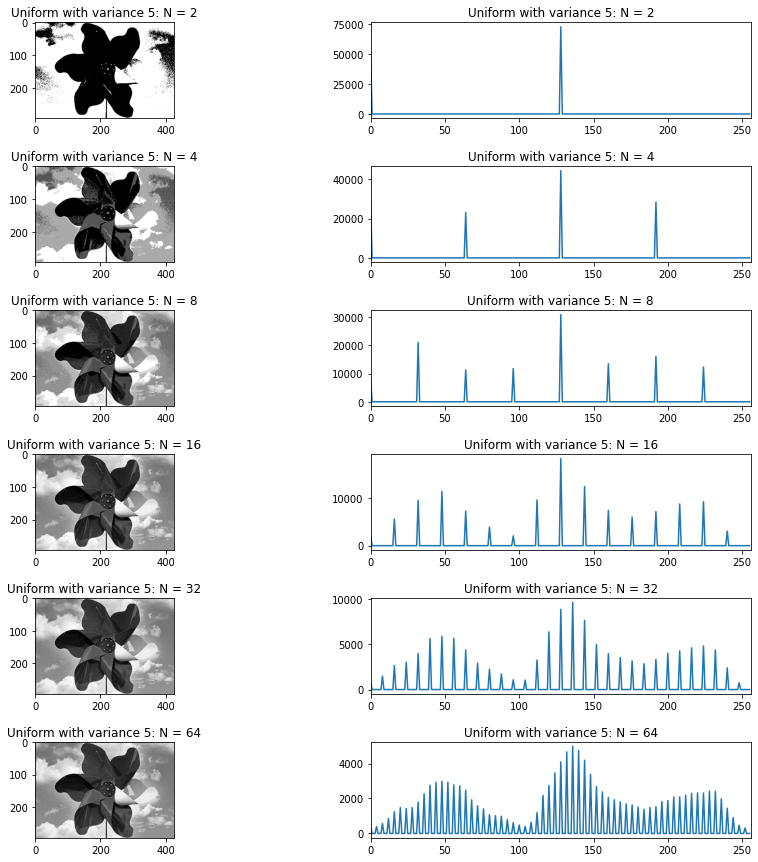

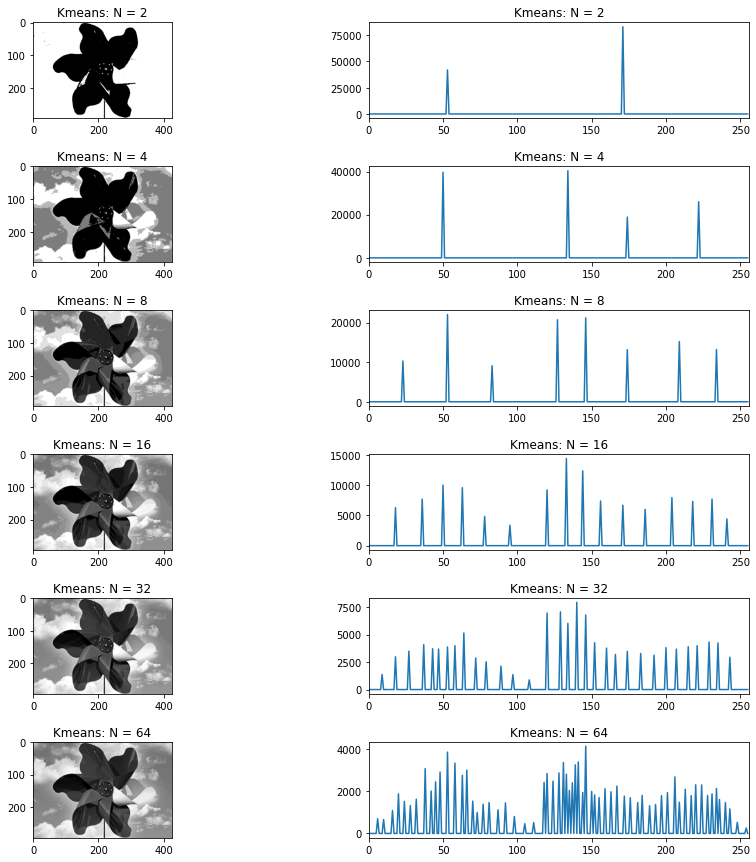

In [21]:

def plot_image_hists(image_dict,title):
  plt.figure(figsize=(15,15))
  for i,key in enumerate(image_dict.keys()):
    plt.subplot2grid((6,2),(i,0))
    plt.title(f"{title}: {key}")
    plt.imshow(image_dict[key], cmap='gray')
    plt.subplot2grid((6,2),(i,1))
    plt.title(f"{title}: {key}")   
    histr = cv2.calcHist([image_dict[key]],[0],None,[256],[0,256])
    plt.plot(histr)
    plt.xlim([0,256])
    plt.subplots_adjust(hspace=.5)

plot_image_hists(uniform_quant_dict,"Uniform with variance 5")
plot_image_hists(kmeans_quant_dict, "Kmeans") 


Write your answer here

# Part 2: Color Histogram Equalization
___

Use the supplied function hist_demo().  
* Observe the following demonstrations:
  * Contrast stretching.
  * Histogram equalization.

In [ ]:
def hist_demo(img):
    # Contrast stretching
    img_dbl = np.float64(img)
    min_im = np.min(np.min(img_dbl))
    max_im = np.max(np.max(img_dbl))
    img_stretched_contrast = np.uint8(255*(img_dbl-min_im)/(max_im-min_im))
    
    # Histogram equalization
    img_hist_eq = cv2.equalizeHist(img) 
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Original image")
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    ax[1].plot(hist)
    ax[1].set_title("Original image histogram")  
    plt.tight_layout(); plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img_stretched_contrast, cmap='gray')
    ax[0].set_title("Contrast stretching image")
    hist = cv2.calcHist([img_stretched_contrast],[0],None,[256],[0,256])
    ax[1].plot(hist)
    ax[1].set_title("Contrast stretching histogram")
    plt.tight_layout(); plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img_hist_eq, cmap='gray')
    ax[0].set_title("Histogram equalization image")
    hist = cv2.calcHist([img_hist_eq],[0],None,[256],[0,256])
    ax[1].plot(hist)
    ax[1].set_title("Histogram equalization histogram")
    plt.tight_layout(); plt.show()

1. Load a **gray image** of your choise ans test these demonstrations. Make sure that the image you choose is indeed affected by both operations.   
    On which images contrast stretching won’t affect?  On which images histogram equalization won’t affect?
    
    Note: 
    If you are experiencing any errors, try to convert the image to uint8 with image_as_ubyte (as we did in the first lab) before using the suplied function.

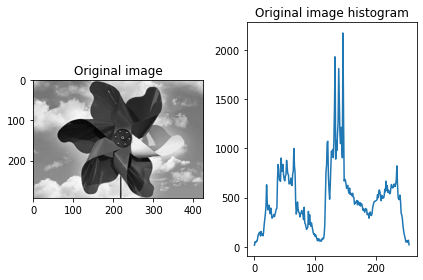

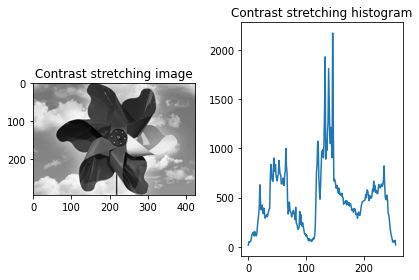

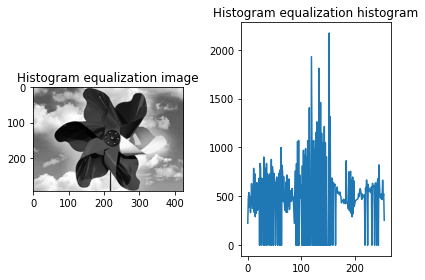

In [ ]:
hist_demo(grayscale_img)


Write your answer here

**Color Histogram Equalization**

2. We now expand Historgram Equalization to color images (RGB).
Write a new function ***hist_eq_rbg(img)*** which performs Histogram Equalization on an RGB image, equalizing each one of its color channels independently (Hint: use the given 1D function demonstrated above). Apply your function on your color image and display the results. Display also the initial and modified channelwise histograms. Are the original colors preserved? Explain.


In [ ]:
def hist_eq_rbg(img):
  plt.imshow(img)
  plt.show()
  channels = cv2.split(img)
  channel_titles = ('b','g','r')
  channel_eq = []
  plt.figure(figsize=(15,10))
  for i,channel in enumerate(channels):

    plt.subplot2grid((3,4),(i,0))
    plt.title(f"original {channel_titles[i]}")
    plt.imshow(channel,cmap='gray')

    plt.subplot2grid((3,4),(i,1))
    plt.title(f"original {channel_titles[i]}")
    plt.plot(cv2.calcHist([channel],[0],None,[256],[0,256]))
    plt.xlim([0,256])

    channel_eq.append(cv2.equalizeHist(channel))

    plt.subplot2grid((3,4),(i,2))
    plt.title(f"equelized {channel_titles[i]}")
    plt.imshow(channel_eq[-1],cmap='gray')

    plt.subplot2grid((3,4),(i,3))
    plt.title(f"equelized {channel_titles[i]}")
    plt.plot(cv2.calcHist([channel_eq[-1]],[0],None,[256],[0,256]))
    plt.xlim([0,256])
  plt.show()
  
  plt.imshow(cv2.merge(np.array(channel_eq)))
  plt.show()


Write your answer here

3. Suggest another approach, which would enable preserving the image colors. (Hint: consider converting to a different color space. Is there a color space, in which the color histogram equalization can be reduced to a 1D problem?)

Write your answer here

4. Implement your approach in a new function called ***hist_eq_color*** and apply it on your color image. Display the modified image. Are the results better? (Remember to convert your image back to RGB when comparing). 

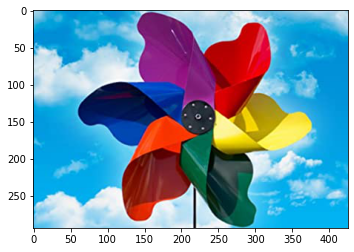

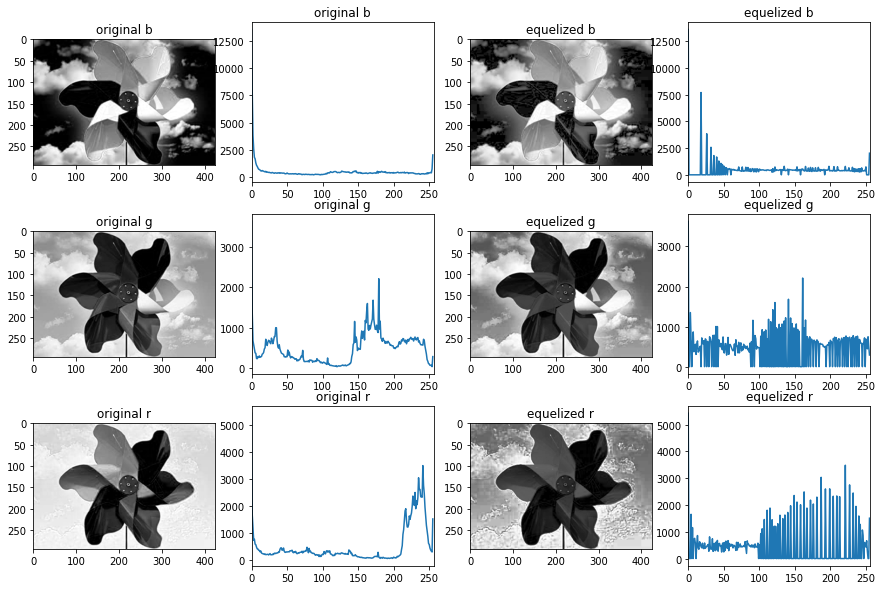

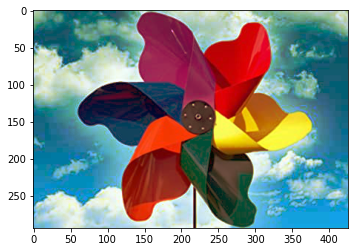

In [ ]:
color_img = io.imread('WeatherVane.bmp')
hist_eq_rbg(color_img)


Write your answer here

# Part 3: Camshift Algorithm


1. We now test the Camshift algorithm for video tracking, as explained in the Lab Manual. Given is a demo script, which loads a short video file 'MOT16-04-trimmed.mp4' from the MOT16 dataset and writes a new video file 'output.mp4' displaying the tracked object. Modify the initial ROI coordinates so that the algorithm tracks an object to your liking and observe the results.

2. Attach several captured frames of the tracked object to your report and answer the following: 
* What color space is used here for tracking and why? 
* What is the main disadvantage of the given algorithm?

Write your answer here

In [ ]:
% ls

autumn.bmp   flower.bmp               Lab2_student.ipynb  printtopdf.ipynb
baloons.bmp  lab_2_preliminary.ipynb  lenna.gif           tiger.bmp
dolphin.bmp  lab_2_preliminary.pdf    MOT16-04-raw.mp4    WeatherVane.bmp


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture('MOT16-04-raw.mp4')
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width,frame_height))

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
#### INSERT THE ROI VALUES HERE ###
x,h,y,w = 0, 0, 0, 0 
track_window = (x,y,w,h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
print(roi)
# convert ROI to HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# create ROI normalized histogram
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        # convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # get probabilty map
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        
        # draw window on frame
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        k = cv2.waitKey(60) & 0xff
        
        if k == 27:
            break
        else:
            # Write the frame into the file 'output.avi'
            out.write(img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()
out.release()

[]
